# Chapter 9 -- Word Embedding

## Introduction

In this tutorial, we will use [PyTorch](https://pytorch.org/) and [Lightning](https://www.lightning.ai/) to create and optimize word embeddings using the incredibly simple network seen below.

<img src="./images/word_embedding_network.png" alt="A simple word embedding network" style="width: 600px;">

This simple network created word embeddings that made two fake movie titles, *Troll 2* and *Gymkata*, cluster together because they were used in similar contexts.

<img src="./images/trained_embedding_graph.png" alt="A graph of the trained word embeddings" style="width: 600px;">

The training data consists of two phrases, where, for the sake of this demonstration, *Troll 2* is considered a single word.

1. "Troll 2 is great!"
2. "Gymkata is great!"

In this tutorial, we will:

- Build and train a Word Embedding Unit from scratch
- Build and train a Word Embedding Unit using `nn.Linear()`
- Use `nn.Embedding()` to load and use pre-trained Word Embeddings
- Build and train a Word Embedding Unit using `nn.Embedding()` and `nn.Linear()`

In [1]:
import torch
import torch.nn as nn

from torch.optim import Adam
from torch.distributions.uniform import Uniform
from torch.utils.data import TensorDataset, DataLoader

import lightning as L

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Create the datasets

Now let's create our training data from two phrases, *Troll 2 is great* and *Gymkata is great*, which gives us a simple 4 word, or token, vocabulary: *Troll 2*, *is*, *great*, *Gymkata*. Our training data consists of two parts: `inputs`, the inputs to the neural network, and `labels`, the expected outputs from the neural networks.

The idea is to have each token in a phrase predict the token that follows. For example, using **one-hot-encoding** to represent each token, since *Troll 2* is the first token in our vocalbuary, we will encode the `input` for *Troll 2* with `[1., 0., 0., 0.]`. And since *Troll 2* predicts the second token, *is*, which is the second token in our vocabulary, we will encode the `label` for *Troll 2* with `[0., 1., 0., 0.]`. Likewise, we can encode the `inputs` and `labels` for *is*, *great* and *Gymkata*.

_NOTE: Gymkata predicts the second token, *is*, so it's label is `[0., 1., 0., 0.]`._

In [2]:
inputs = torch.tensor([
    [1., 0., 0., 0.],  # one-hot-encoding for Troll 2...
    [0., 1., 0., 0.],  # ...is
    [0., 0., 1., 0.],  # ...great
    [0., 0., 0., 1.]]) # ...Gymkata

labels = torch.tensor([
    [0., 1., 0., 0.],  # "Troll 2" is followed by "is"
    [0., 0., 1., 0.],  # "is" is followed by "great"
    [0., 0., 0., 1.],  # "great" isn't followed by anything, but we'll pretend it was followed by "Gymkata"
    [0., 1., 0., 0.]]) # "Gymkata", just like "Troll 2", is followed by "is".

Now that we have created the data that we want to train the embeddings with, we'll store it in a `DataLoader`. Since our dataset is so small, using a `DataLoader` is a little bit of an overkill, but it it's easy to do, and it will allow us to easily scale up to a much larger vocabulary when the time comes.

In [3]:
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

## Build and train a Word Embedding Unit from scratch

Now that we have the data and `DataLoader` all worked out, let's create the `class` that will create the word embeddings for each token in the vocabulary.

In [4]:
class WordEmbeddingFromScratch(L.LightningModule):

    def __init__(self):

        super().__init__()
        L.seed_everything(seed=42)

        # We're initializing the weights using values from a uniform distribtion
        # that goes from -0.5 to 0.5 (notated as U(-0.5, 0.5). This is because of 
        # how nn.Linear() initializes weights; nn.Linear() uses U(-sqrt(k), sqrt(k)), 
        # where k=1/in_features. In our case, we have 4 inputs, so k=1/4 = 0.25. 
        # And the sqrt(0.25) = 0.5. Thus, nn.Linear() would use U(-0.5, 0.5) to 
        # initialize the weights, so that's what we'll do here as well.

        min_value = -0.5
        max_value = 0.5

        # Now we initialize the weights that feed 4 inputs (one for each unique word)
        # into the 2 nodes in the hidden layer (top and bottom nodes). Because we want 
        # words (or tokens) that are used in the same context to have similar weights, 
        # we are excluding bias terms from the connections from the inputs to the nodes 
        # in the hidden layer (alternatively, you could think that we set the bias 
        # terms to 0 and are not going to optimize them). We're using nn.Parameter() 
        # here instead of torch.tensor() because we want to easily print out the 
        # parameters before and after training. Parameters are just tensors that are 
        # added to model's parameter list.

        self.input1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.input2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.input3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.input4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        # Now we initialize the weights that come out of the hidden layer to 
        # "output". Again, we are excluding bias terms. This time, we exclude 
        # them simply because we do not need them.
        self.output1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        # For the loss function, we'll use CrossEntropyLoss, which we'll use in 
        # training_step(). The nn.CrossEntropyLoss automatically applies softmax 
        # for us, so we don't need to import it.
        self.loss = nn.CrossEntropyLoss()


    def forward(self, input):
        # The input is delivered inside of a list, like this
        #   [[1., 0., 0., 0.]]
        # and it's just easier if we remove the extra pair of brackets:
        #   [1., 0., 0., 0.]
        input = input[0]

        # First, for the top node in the hidden layer, we multiply each input 
        # by its weight, and then calculate the sum of those products...
        inputs_to_top_hidden = (
            (input[0] * self.input1_w1)
            +
            (input[1] * self.input2_w1)
            +
            (input[2] * self.input3_w1)
            +
            (input[3] * self.input4_w1)
        )

        # Then, for the bottom node in the hidden layer,we multiply each input 
        # by its weight, and then calculate the sum of those products.
        inputs_to_bottom_hidden = (
            (input[0] * self.input1_w2)
            +
            (input[1] * self.input2_w2)
            +
            (input[2] * self.input3_w2)
            +
            (input[3] * self.input4_w2)
        )

        # Now, in theory, we could run inputs_to_top_hidden and inputs_to_bottom_hidden 
        # through linear activation functions, but the outputs would be the exact same 
        # as in the inputs, so we can just skip that step and instead compute the 4 output 
        # values from the 2 nodes in hidden layer by summing the products of the hidden 
        # layer values and a pair of weights for each output.
        output1 = (
            (inputs_to_top_hidden * self.output1_w1)
            +
            (inputs_to_bottom_hidden * self.output1_w2))
        output2 = (
            (inputs_to_top_hidden * self.output2_w1)
            +
            (inputs_to_bottom_hidden * self.output2_w2))
        output3 = (
            (inputs_to_top_hidden * self.output3_w1)
            +
            (inputs_to_bottom_hidden * self.output3_w2))
        output4 = (
            (inputs_to_top_hidden * self.output4_w1)
            +
            (inputs_to_bottom_hidden * self.output4_w2))

        # Now we need to concatenate the 4 output tensors so that we can run them through
        # the SoftMax function. However, because they are tensors (and have gradients 
        # attached to them), we can't just combine them in a simple list like this:
        # output_values = [output1, output2, output3, output4]
        # THIS WILL NOT WORK because that would strip off the gradients. Instead, we use 
        # torch.stack(), which retains the gradients.

        output_presoftmax = torch.stack([output1, output2, output3, output4])
        # The the loss function we are using, nn.CrossEntropyLoss, automatically applies 
        # softmax for us, so we need to do that ourselves. If we want to actually use this 
        # network to predict the next word (instead of just using it for the Word Embedding 
        # values), then we'll need to apply the softmax() function ourselves (or just look 
        # to see what output value is largest).

        return(output_presoftmax)


    def configure_optimizers(self):
        # configure_optimizers() configures the optimizer we want to use for backpropagation.

        return Adam(self.parameters(), lr=0.1)


    def training_step(self, batch):
        # training_step() takes a step of gradient descent.

        input_i, label_i = batch # collect input
        output_i = self.forward(input_i) # run input through the neural network
        loss = self.loss(output_i, label_i[0]) ## loss = cross entropy

        return loss

Now that we have created our new `class`, `WordEmbeddingFromScratch`, let's create a model and print out the initial parameters.

In [5]:
modelFromScratch = WordEmbeddingFromScratch()

print("Before optimization, the parameters are:")
for name, param in modelFromScratch.named_parameters():
    print(
        name,
        torch.round(param.data, decimals=2))

Seed set to 42


Before optimization, the parameters are:
input1_w1 tensor(0.3800)
input1_w2 tensor(0.4200)
input2_w1 tensor(-0.1200)
input2_w2 tensor(0.4600)
input3_w1 tensor(-0.1100)
input3_w2 tensor(0.1000)
input4_w1 tensor(-0.2400)
input4_w2 tensor(0.2900)
output1_w1 tensor(0.4400)
output1_w2 tensor(-0.3700)
output2_w1 tensor(0.4300)
output2_w2 tensor(0.0900)
output3_w1 tensor(0.3700)
output3_w2 tensor(0.0700)
output4_w1 tensor(0.2400)
output4_w2 tensor(-0.0700)


Notice how the weights for **input1** (`w1 = 0.38` and `w2 = 0.42`) and **input4** (`w1 = -0.24` and `w2 = 0.29`) are very different, even though they both represent movie titles (*Troll 2* and *Gymkata*) that are used in the same context. We can visualize how similar, and different, the embeddings are for all four tokens by plotting them on a graph that has the **w1** values, the embedding values that go to the top node in the hidden layer, on the x-axis and the **w2** values, the embedding values that go to the bottom node in the hidden layer, on the y-axis.

First, let's organize the data into a Pandas `DataFrame()`.

In [6]:
data = {
    "w1": [
        modelFromScratch.input1_w1.item(),  # item() pulls out the tensor value as a float
        modelFromScratch.input2_w1.item(),
        modelFromScratch.input3_w1.item(),
        modelFromScratch.input4_w1.item()],
    "w2": [
        modelFromScratch.input1_w2.item(),
        modelFromScratch.input2_w2.item(),
        modelFromScratch.input3_w2.item(),
        modelFromScratch.input4_w2.item()],
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"]
}

df = pd.DataFrame(data)

print("Data in the DataFrame format:")
print(df)

Data in the DataFrame format:
         w1        w2    token   input
0  0.382269  0.415004   Troll2  input1
1 -0.117136  0.459306       is  input2
2 -0.109552  0.100895    great  input3
3 -0.243428  0.293641  Gymkata  input4


Now let's use the dataframe we just created, `df`, and let's draw a scatter plot of the weights, `w1` and `w2`, for each token in the vocabulary.

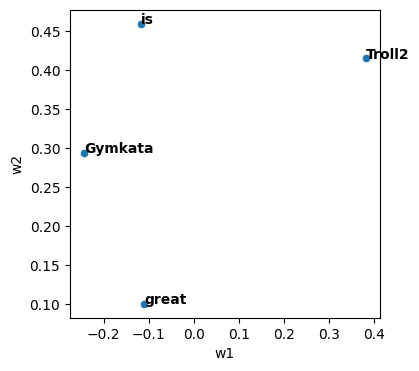

In [7]:
plt.figure(figsize=(4,4))
sns.scatterplot(data=df, x="w1", y="w2")

# Add the token that each dot represents to the graph
# Troll 2
plt.text(
    df.w1[0], df.w2[0], df.token[0],
    horizontalalignment='left',
    size='medium',
    weight='semibold')

# is
plt.text(
    df.w1[1], df.w2[1], df.token[1],
    horizontalalignment='left',
    size='medium',
    weight='semibold')

# great
plt.text(
    df.w1[2], df.w2[2], df.token[2],
    horizontalalignment='left',
    size='medium',
    weight='semibold')

# Gymkata
plt.text(
    df.w1[3], df.w2[3], df.token[3],
    horizontalalignment='left',
    size='medium',
    weight='semibold');

In the graph we can see that the weights for *Troll 2* (representing **input1**) and *Gymkata* (representing **input4**) are no more similar to each other than the other inputs. However, by training this neural network, we hope that those weights will become similar. So lets create a `Trainer` and train the embedding network.

In [8]:
trainer = L.Trainer(max_epochs=100)
trainer.fit(modelFromScratch, train_dataloaders=dataloader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | CrossEntropyLoss | 0      | train
  | other params | n/a              | 16     | n/a  
----------------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
c:\Users\Sébastien\Documents\data_science\machine_learning\statsquest_neural_networks\.env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many wo

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Now, with the trained neural network, let's print out the values for each weight...

In [9]:
print("After optimization, the parameters are:")
for name, param in modelFromScratch.named_parameters():
    print(
        name,
        torch.round(param.data, decimals=2))

After optimization, the parameters are:
input1_w1 tensor(2.0200)
input1_w2 tensor(1.9400)
input2_w1 tensor(-2.1800)
input2_w2 tensor(2.3200)
input3_w1 tensor(-2.0300)
input3_w2 tensor(-2.1600)
input4_w1 tensor(1.6900)
input4_w2 tensor(1.8900)
output1_w1 tensor(1.2600)
output1_w2 tensor(-1.7700)
output2_w1 tensor(3.0800)
output2_w2 tensor(1.3600)
output3_w1 tensor(-1.5800)
output3_w2 tensor(0.8800)
output4_w1 tensor(-1.5700)
output4_w2 tensor(-3.2900)


After **100** epochs, the weights for **input1** (`w1 = 2.02` and `w2 = 1.94`) are now relatively similar to the weights for **input4** (`w1 = 1.69` and `w2 = 1.89`). Just like before, we can illustrate how similar, and different, the embeddings are for all four tokens by plotting them on a graph that has the **w1** values on the x-axis and the **w2** values on the y-axis.

In [10]:
data_opt = {
    "w1": [
        modelFromScratch.input1_w1.item(),
        modelFromScratch.input2_w1.item(),
        modelFromScratch.input3_w1.item(),
        modelFromScratch.input4_w1.item()],
    "w2": [
        modelFromScratch.input1_w2.item(),
        modelFromScratch.input2_w2.item(),
        modelFromScratch.input3_w2.item(),
        modelFromScratch.input4_w2.item()],
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"]
}

df_opt = pd.DataFrame(data_opt)

print("Data 'optimized' in the DataFrame format:")
print(df_opt)

Data 'optimized' in the DataFrame format:
         w1        w2    token   input
0  2.015867  1.941373   Troll2  input1
1 -2.181995  2.318636       is  input2
2 -2.028367 -2.161824    great  input3
3  1.691295  1.894237  Gymkata  input4


Then draw the scatterplot.

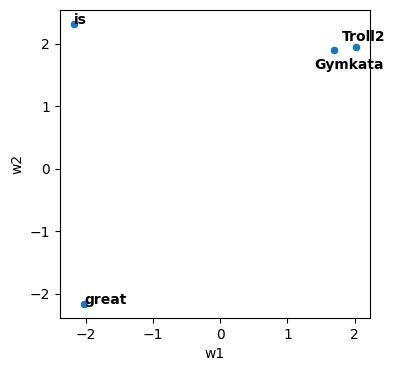

In [11]:
plt.figure(figsize=(4,4))
sns.scatterplot(data=df_opt, x="w1", y="w2")

# For Troll2 and and Gymkata, we're adding offsets to where to print 
# the tokens because otherwise they will be so close to each other 
# that they will overlap and be unreadable.

# Troll 2
plt.text(
    df_opt.w1[0]-.2, df_opt.w2[0]+.1, df_opt.token[0],
    horizontalalignment='left',
    size='medium',
    weight='semibold')

# is
plt.text(
    df_opt.w1[1], df_opt.w2[1], df_opt.token[1],
    horizontalalignment='left',
    size='medium',
    weight='semibold')

# great
plt.text(
    df_opt.w1[2], df_opt.w2[2], df_opt.token[2],
    horizontalalignment='left',
    size='medium',
    weight='semibold')

# Gymkata
plt.text(
    df_opt.w1[3]-.3, df_opt.w2[3]-.3, df_opt.token[3],
    horizontalalignment='left',
    size='medium',
    weight='semibold');

Therefore, after training the neural network, we see that the weights for *Troll 2* and *Gymkata* are relatively similar compared to the weights for the other tokens. This is because both tokens have the same context.

Lastly, we can verify that each token in the vacabulary correctly predicts the token that follows it by running the **one-hot-encoded** input values for each token through the neural network.

In [ ]:
# First, let's create a softmax object
softmax = nn.Softmax(dim=0)  # dim=0 applies softmax to the only dimension (the list of values)

# Note that the forward() method is flattening the input, i.e., input = input[0].
# Because we are stacking 4 scalar values, the shape of the output vector 
# is a 1D tensor with shape (4), i.e., [val1, val2, val3, val4]:
# output_presoftmax = torch.stack([output1, output2, output3, output4])

# print the predictions for "Troll 2"
print(
    "Prediction for 'Troll 2':",
    torch.round(
        softmax(
            modelFromScratch(
                torch.tensor(
                    [[1., 0., 0., 0.]])))))

# print the predictions for "is"
print(
    "Prediction for 'is':",
    torch.round(
        softmax(
            modelFromScratch(
                torch.tensor(
                    [[0., 1., 0., 0.]])))))

# print the predictions for "great"
print(
    "Prediction for 'great':",
    torch.round(
        softmax(
            modelFromScratch(
                torch.tensor(
                    [[0., 0., 1., 0.]])))))

# print the predictions for "Gymkata"
print(
    "Prediction for 'Gymkata':",
    torch.round(
        softmax(
            modelFromScratch(
                torch.tensor(
                    [[0., 0., 0., 1.]])))))

Prediction for 'Troll 2': tensor([0., 1., 0., 0.], grad_fn=<RoundBackward0>)
Prediction for 'is': tensor([0., 0., 1., 0.], grad_fn=<RoundBackward0>)
Prediction for 'great': tensor([0., 0., 0., 1.], grad_fn=<RoundBackward0>)
Prediction for 'Gymkata': tensor([0., 1., 0., 0.], grad_fn=<RoundBackward0>)


And we see that all tokens correctly predict (give the highest probability to) the token that follows them. In this case, both *Troll 2* and *Gymkata* both correctly predict the second token, **is**, with probability **1.0**.

## Build and train a Word Embedding Unit using `nn.Linear()`

Now that we can make a Word Embedding network from scratch, let's simplify the code using `nn.Linear()`. This method will make initialzing the tensors easy and the math we do in the `forward()` step will also be much simpler.

In [13]:
class WordEmbeddingWithLinear(L.LightningModule):

    def __init__(self):

        super().__init__()
        L.seed_everything(seed=42)

        # In order to initialize weights from the 4 inputs (one for each unique word)
        # to the 2 nodes in the hidden layer (top and bottom nodes), we simply make
        # one call to nn.Linear() where in_features specifies the number of inputs 
        # and out_features specifies the number of nodes we are connecting them to. 
        # Since we don't want to use bias terms, we set bias=False.

        self.input_to_hidden = nn.Linear(in_features=4, out_features=2, bias=False)

        # Now, in order to connect the 2 nodes in the hidden layer to the 4 outputs, 
        # we make one call to nn.Linear(), where in_features specifies the number of
        # nodes in hidden layer and out_features specifies the number of output 
        # values we want. And again, we can set bias=False.
        
        self.hidden_to_output = nn.Linear(in_features=2, out_features=4, bias=False)

        # We'll use CrossEntropyLoss in training_step()
        self.loss = nn.CrossEntropyLoss()


    def forward(self, input):

        # Unlike before, where we did all the math by hand, now we can simply pass the 
        # input values to the weights we created with nn.Linear() between the input and 
        # the hidden layer and save the result in "hidden". Moreover, we don't need to 
        # strip off the extra brackets from the input. the Linear ojbect knows what to do.

        hidden = self.input_to_hidden(input)

        # Then we pass "hidden" to the weights we created with nn.Linear() between the 
        # hidden layer and the output.

        output_values = self.hidden_to_output(hidden)

        return(output_values)


    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.1)


    def training_step(self, batch):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = self.loss(output_i, label_i)

        return loss

Now that we have created our new `WordEmbeddingWithLinear` class, let's create a model and print out the initial parameters.

In [14]:
modelLinear = WordEmbeddingWithLinear()

print("Before optimization, the parameters are:")
for name, param in modelLinear.named_parameters():
    print(name, torch.round(param.data, decimals=2))

Seed set to 42


Before optimization, the parameters are:
input_to_hidden.weight tensor([[ 0.3800,  0.4200, -0.1200,  0.4600],
        [-0.1100,  0.1000, -0.2400,  0.2900]])
hidden_to_output.weight tensor([[ 0.6200, -0.5200],
        [ 0.6100,  0.1300],
        [ 0.5200,  0.1000],
        [ 0.3400, -0.1000]])


We then create a `DataFrame` with the embedding values.

In [15]:
data_embedding = {
    # Unlike before, when we called item() on each individual Weight, 
    # now that we are using nn.Linear, we access the Weights with 
    # the `weight` attribute`. We then have to remove the gradients
    # associated with each Weight, so we also call .detach(). Lastly, 
    # we then convert the tensor to a numpy array with  numpy().

    # [0] = Weights to top activation function
    "w1": modelLinear.input_to_hidden.weight.detach()[0].numpy(),
    # [1] = Weights to bottom activation function
    "w2": modelLinear.input_to_hidden.weight.detach()[1].numpy(),
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"]
}

df_embedding = pd.DataFrame(data_embedding)

print("Embedding vectors in DataFrame:")
print(df_embedding)

Embedding vectors in DataFrame:
         w1        w2    token   input
0  0.382269 -0.109552   Troll2  input1
1  0.415004  0.100895       is  input2
2 -0.117136 -0.243428    great  input3
3  0.459306  0.293641  Gymkata  input4


Finally we draw a scatter plot of the new, initial, unoptimized, embedding values.

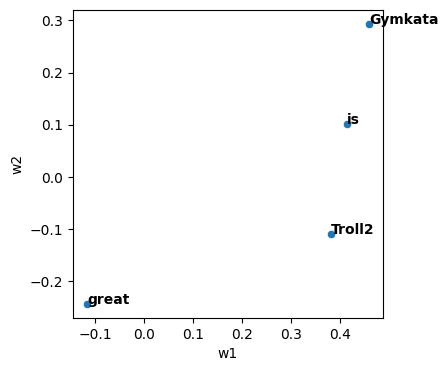

In [16]:
plt.figure(figsize=(4,4))
sns.scatterplot(data=df_embedding, x="w1", y="w2")

# Add the token that each dot represents to the graph
# Troll 2
plt.text(
    df_embedding.w1[0], df_embedding.w2[0], df_embedding.token[0],
    horizontalalignment='left',
    size='medium',
    weight='semibold')

# is
plt.text(
    df_embedding.w1[1], df_embedding.w2[1], df_embedding.token[1],
    horizontalalignment='left',
    size='medium',
    weight='semibold')

# great
plt.text(
    df_embedding.w1[2], df_embedding.w2[2], df_embedding.token[2],
    horizontalalignment='left',
    size='medium',
    weight='semibold')

# Gymkata
plt.text(
    df_embedding.w1[3], df_embedding.w2[3], df_embedding.token[3],
    horizontalalignment='left',
    size='medium',
    weight='semibold');

We see that the embedding values for *Troll 2* and *Gymkata* are relatively different. So let's train the model and see if they become more similar.

In [17]:
trainer = L.Trainer(max_epochs=100)
trainer.fit(modelLinear, train_dataloaders=dataloader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | input_to_hidden  | Linear           | 8      | train
1 | hidden_to_output | Linear           | 8      | train
2 | loss             | CrossEntropyLoss | 0      | train
--------------------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
c:\Users\Sébastien\Documents\data_science\machine_learning\statsquest_neural_networks\.env\Lib\site-packages\lightning\pytorch\trainer\c

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [18]:
print("After optimization (nn.Linear), the parameters are:")
for name, param in modelLinear.named_parameters():
    print(name, param.data)

After optimization (nn.Linear), the parameters are:
input_to_hidden.weight tensor([[ 2.5104, -1.0177, -1.9742,  2.4355],
        [-0.0688,  2.4824, -1.8190, -0.2228]])
hidden_to_output.weight tensor([[-0.3022, -1.0102],
        [ 3.2008, -0.3850],
        [-0.6693,  2.1814],
        [-2.6841, -2.9578]])


In [19]:
data_embedding_opt = {
    "w1": modelLinear.input_to_hidden.weight.detach()[0].numpy(),
    "w2": modelLinear.input_to_hidden.weight.detach()[1].numpy(),
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"]
}

df_embedding_opt = pd.DataFrame(data_embedding_opt)

print("Embedding vector after optimization:")
print(df_embedding_opt)

Embedding vector after optimization:
         w1        w2    token   input
0  2.510447 -0.068821   Troll2  input1
1 -1.017650  2.482441       is  input2
2 -1.974159 -1.818951    great  input3
3  2.435523 -0.222807  Gymkata  input4


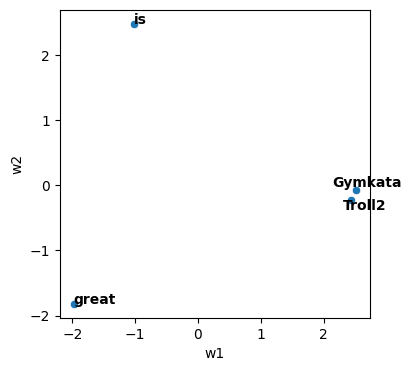

In [20]:
plt.figure(figsize=(4,4))
sns.scatterplot(data=df_embedding_opt, x="w1", y="w2")

# Troll 2
plt.text(
    df_embedding_opt.w1[0]-.2, df_embedding_opt.w2[0]-.3, df_embedding_opt.token[0],
    horizontalalignment='left',
    size='medium',
    weight='semibold')

# is
plt.text(
    df_embedding_opt.w1[1], df_embedding_opt.w2[1], df_embedding_opt.token[1],
    horizontalalignment='left',
    size='medium',
    weight='semibold')

# great
plt.text(
    df_embedding_opt.w1[2], df_embedding_opt.w2[2], df_embedding_opt.token[2],
    horizontalalignment='left',
    size='medium',
    weight='semibold')

# Gymkata
plt.text(
    df_embedding_opt.w1[3]-.3, df_embedding_opt.w2[3]+.2, df_embedding_opt.token[3],
    horizontalalignment='left',
    size='medium',
    weight='semibold');

And, after training the model, we see that the embedding values for *Troll 2* and *Gymkata* are more similar than before.

Lastly, we can verify that each token in the vacabulary correctly predicts the token that follows it by running the **one-hot-encoded** input values for each token through the neural network.

In [21]:
softmax = nn.Softmax(dim=1) # dim=0 applies softmax to rows, dim=1 applies softmax to columns

# Unlike the modelFromScratch model, nn.Linear produces a 2D tensor with shape (1, 4),
# preserving the batch dimension: [[val1, val2, val3, val4]].
# Since the classes are arranged across the columns (Dimension 1), we use dim=1 
# to squash the values across the row so they sum to 1.

print(
    "Prediction for 'Troll 2':",
    torch.round(
        softmax(
            modelLinear(
                torch.tensor(
                    [[1., 0., 0., 0.]])))))

print(
    "Prediction for 'is':",
    torch.round(
        softmax(
            modelLinear(
                torch.tensor(
                    [[0., 1., 0., 0.]])))))

print(
    "Prediction for 'great':",
    torch.round(
        softmax(
            modelLinear(
                torch.tensor(
                    [[0., 0., 1., 0.]])))))

print(
    "Prediction for 'Gymkata':",
    torch.round(
        softmax(
            modelLinear(
                torch.tensor(
                    [[0., 0., 0., 1.]])))))

Prediction for 'Troll 2': tensor([[0., 1., 0., 0.]], grad_fn=<RoundBackward0>)
Prediction for 'is': tensor([[0., 0., 1., 0.]], grad_fn=<RoundBackward0>)
Prediction for 'great': tensor([[0., 0., 0., 1.]], grad_fn=<RoundBackward0>)
Prediction for 'Gymkata': tensor([[0., 1., 0., 0.]], grad_fn=<RoundBackward0>)


## Use `nn.Embedding()` to load and use pre-trained Word Embeddings

Now that we have created embeddings for each token in the vocabulary, we can store them in an `nn.Embedding()` object so that we can access them with the tokens, rather than the one-hot-encoded versions of the tokens. This makes them easily portable to other applications.

First, let's just print out the embedding values that we created in modelLinear and that we want to add to an `nn.Embedding()` object.

In [22]:
modelLinear.input_to_hidden.weight

Parameter containing:
tensor([[ 2.5104, -1.0177, -1.9742,  2.4355],
        [-0.0688,  2.4824, -1.8190, -0.2228]], requires_grad=True)

Now let's create an `nn.Embedding()` object and add those Embedding Values to it.

In [23]:
# We have to transpose the original embedding values (from w1 and w2) for nn.Embedding()
# and we do this with adding a '.T' to modelLinear.input_to_hidden.weight.T
word_embeddings = nn.Embedding.from_pretrained(modelLinear.input_to_hidden.weight.T)

Now let's print out the weights to make sure they are what we expect them to be.

In [24]:
word_embeddings.weight

Parameter containing:
tensor([[ 2.5104, -0.0688],
        [-1.0177,  2.4824],
        [-1.9742, -1.8190],
        [ 2.4355, -0.2228]])

Now we can access the embeddings for each token directly with an index between 0 and 3.

In [25]:
word_embeddings(torch.tensor(0))  # retrieve the embedding values for 'Troll2'

tensor([ 2.5104, -0.0688])

We can also create a dictionary and access the embedding values with words or tokens instead.

In [26]:
vocab = {
    'Troll2': 0,
    'is': 1,
    'great': 2,
    'Gymkata': 3}

In [28]:
print("Embedding for 'Troll2':")
word_embeddings(
    torch.tensor(
        vocab['Troll2']))

Embedding for 'Troll2':


tensor([ 2.5104, -0.0688])

In [29]:
print("Embedding for 'Gymkata':")
word_embeddings(
    torch.tensor(
        vocab['Gymkata']))

Embedding for 'Gymkata':


tensor([ 2.4355, -0.2228])

## Build and train a Word Embedding Unit using `nn.Embedding()` and `nn.Linear()`

Although less commonly done, we can replace `nn.Linear()` from the inputs to the activation functions with `nn.Embedding()` and train the embeddings directly in the lookup table.

In [30]:
class WordEmbeddingWithEmbedding(L.LightningModule):

    def __init__(self):
        super().__init__()
        L.seed_everything(seed=42)

        self.embed = nn.Embedding(4, 2)  # 4 = number of words in the vocabulary,
                                         # 2 = numbers per embedding
        self.hidden_to_output = nn.Linear(2, 4, bias=False)

        self.loss = nn.CrossEntropyLoss()


    def forward(self, input):
        hidden = self.embed(input[0])
        output_values = self.hidden_to_output(hidden)

        return(output_values)


    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.1)


    def training_step(self, batch):
        input_i, label_i = batch
        output_i = self.forward(input_i[0])
        loss = self.loss(output_i, label_i[0])

        return loss

In [42]:
# nn.Embedding() applies one-hot-encoding to the input for us, so
# the data that we use for training will look different from before.
inputsForEmbed = torch.tensor([[0], [1], [2], [3]])  # Troll2 = 0, is = 1, great = 2, Gymkata = 3
labels = torch.tensor([[0., 1., 0., 0.], [0., 0., 1., 0.], [0., 0., 0., 1.], [0., 1., 0., 0.]])

datasetForEmbed = TensorDataset(inputsForEmbed, labels)
dataloaderForEmbed = DataLoader(datasetForEmbed)

In [43]:
modelEmbed = WordEmbeddingWithEmbedding()

print("Before optimization, the parameters are:")
for name, param in modelEmbed.named_parameters():
    print(name, param.data)

Seed set to 42


Before optimization, the parameters are:
embed.weight tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863],
        [ 2.2082, -0.6380]])
hidden_to_output.weight tensor([[ 0.5451,  0.1045],
        [-0.3301,  0.1802],
        [-0.3258, -0.0829],
        [-0.2872,  0.4691]])


In [44]:
weights = modelEmbed.embed.weight.detach().numpy()
w1 = [weights[0][0], weights[1][0], weights[2][0], weights[3][0]]
w1

[np.float32(0.33669037),
 np.float32(0.23446237),
 np.float32(-1.1228564),
 np.float32(2.2082014)]

In [45]:
w2 = [weights[0][1], weights[1][1], weights[2][1], weights[3][1]]
w2

[np.float32(0.1288094),
 np.float32(0.23033303),
 np.float32(-0.18632829),
 np.float32(-0.63799703)]

In [46]:
data = {
    "w1": w1,
    "w2": w2,
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"]
}

df = pd.DataFrame(data)
df

,w1,w2,token,input
0,0.336690,0.128809,Troll2,input1
1,0.234462,0.230333,is,input2
2,-1.122856,-0.186328,great,input3
3,2.208201,-0.637997,Gymkata,input4


Text(2.2082014083862305, -0.637997031211853, 'Gymkata')

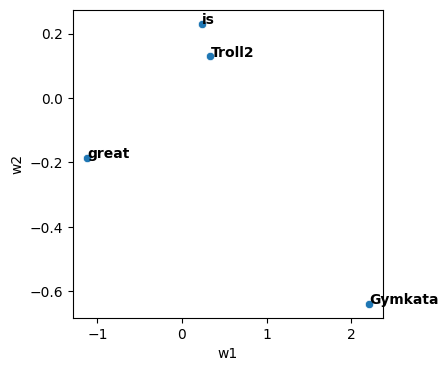

In [47]:
plt.figure(figsize=(4,4))
sns.scatterplot(data=df, x="w1", y="w2")

plt.text(
    df.w1[0], df.w2[0], df.token[0],
    horizontalalignment='left',
    size='medium',
    color='black',
    weight='semibold') # Troll 2

plt.text(
    df.w1[1], df.w2[1], df.token[1],
    horizontalalignment='left',
    size='medium',
    color='black',
    weight='semibold') # is
plt.text(
    df.w1[2], df.w2[2], df.token[2],
    horizontalalignment='left',
    size='medium',
    color='black',
    weight='semibold') # great
plt.text(
    df.w1[3], df.w2[3], df.token[3],
    horizontalalignment='left',
    size='medium',
    color='black',
    weight='semibold') # Gymkata

In [48]:
trainer = L.Trainer(max_epochs=100)
trainer.fit(modelEmbed, train_dataloaders=dataloaderForEmbed)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | embed            | Embedding        | 8      | train
1 | hidden_to_output | Linear           | 8      | train
2 | loss             | CrossEntropyLoss | 0      | train
--------------------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
c:\Users\Sébastien\Documents\data_science\machine_learning\statsquest_neural_networks\.env\Lib\site-packages\lightning\pytorch\trainer\c

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [49]:
print("After optimization, the parameters are:")
for name, param in modelEmbed.named_parameters():
    print(name, param.data)

After optimization, the parameters are:
embed.weight tensor([[ 1.7255,  2.6477],
        [ 0.9756, -2.5702],
        [-3.5512, -0.1337],
        [ 3.3123,  0.9554]])
hidden_to_output.weight tensor([[-6.0445e-01,  1.6247e-01],
        [ 1.6389e+00,  1.7619e+00],
        [ 1.6950e-03, -2.8041e+00],
        [-2.8600e+00,  7.4534e-02]])


In [50]:
weights = modelEmbed.embed.weight.detach().numpy()
w1 = [weights[0][0], weights[1][0], weights[2][0], weights[3][0]]
w2 = [weights[0][1], weights[1][1], weights[2][1], weights[3][1]]

In [51]:
data = {
    "w1": w1,
    "w2": w2,
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"]
}

df = pd.DataFrame(data)
df

,w1,w2,token,input
0,1.725517,2.647727,Troll2,input1
1,0.975586,-2.570216,is,input2
2,-3.551210,-0.133742,great,input3
3,3.312256,0.955405,Gymkata,input4


Text(3.012256383895874, 1.155404806137085, 'Gymkata')

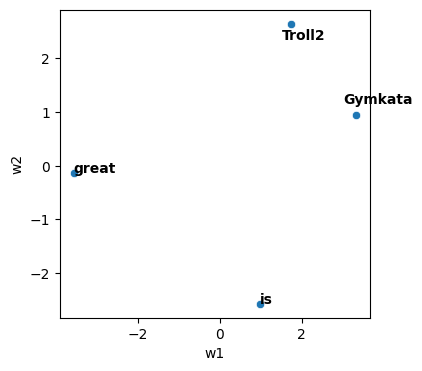

In [52]:
plt.figure(figsize=(4,4))
sns.scatterplot(data=df, x="w1", y="w2")

plt.text(
    df.w1[0]-0.2, df.w2[0]-0.3, df.token[0],
    horizontalalignment='left',
    size='medium',
    weight='semibold') # Troll 2
plt.text(
    df.w1[1], df.w2[1], df.token[1],
    horizontalalignment='left',
    size='medium',
    weight='semibold') # is
plt.text(
    df.w1[2], df.w2[2], df.token[2],
    horizontalalignment='left',
    size='medium',
    weight='semibold') # great
plt.text(
    df.w1[3]-0.3, df.w2[3]+0.2, df.token[3],
    horizontalalignment='left',
    size='medium',
    weight='semibold') # Gymkata

In [ ]:
## Let's see what the model predicts
softmax = nn.Softmax(dim=0) ## dim=0 applies softmax to rows, dim=1 applies softmax to columns

print(torch.round(softmax(modelEmbed(torch.tensor([0])).detach()), decimals=2)) # print the predictions for "Troll2"
print(torch.round(softmax(modelEmbed(torch.tensor([1])).detach()), decimals=2)) # print the predictions for "is"
print(torch.round(softmax(modelEmbed(torch.tensor([2])).detach()), decimals=2)) # print the predictions for "great"
print(torch.round(softmax(modelEmbed(torch.tensor([3])).detach()), decimals=2)) # print the predictions for "Gymkata"

tensor([0., 1., 0., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 0., 1.])
tensor([0., 1., 0., 0.])
